In [ ]:
!pip install pyannote.audio==2.1.1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.7/390.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import librosa
import torch
from sklearn.cluster import KMeans
from pyannote.core import Annotation, Segment
from pyannote.metrics.detection import DetectionErrorRate


In [3]:
BASE_DIR  = '/kaggle/input/english-multispeaker-corpus-for-voice-cloning/VCTK-Corpus/VCTK-Corpus'
TXT_DIR =  os.path.join(BASE_DIR, 'txt')
AUDIO_DIR = os.path.join(BASE_DIR, 'wav48')

SAMPLING_RATE = 22050
MAX_DURATION = 8
SR_DOWNSAMPLE = 2

In [4]:
speaker_ids = sorted(os.listdir(TXT_DIR))
print('number of speakers is', len(speaker_ids))

number of speakers is 108


In [5]:
def get_speech(speaker_id = np.random.choice(speaker_ids), passage_id = None):
    if not passage_id:
        speaker_passage_path = os.path.join(TXT_DIR, speaker_id)
        passage_id = np.random.choice(os.listdir(speaker_passage_path))[:-4]
        
    text_path = os.path.join(TXT_DIR, speaker_id, passage_id + '.txt')
    speech_path = os.path.join(AUDIO_DIR, speaker_id, passage_id + '.wav')
    
    x, sr = librosa.load(speech_path)
    
    with open(text_path, 'r') as text_file:
        text = text_file.read()
        
    return x, sr, text, speech_path
        
        
x, sr, text, speech_path = get_speech()
print('sampling rate', sr, 'hz')
print('number of samples', len(x))
print('duration', round(len(x)/sr, 2), 'seconds')

sampling rate 22050 hz
number of samples 64974
duration 2.95 seconds


In [6]:
import IPython.display as ipd
print(text)
ipd.Audio(speech_path)

It has been a major success.


In [72]:
wave_paths = []
for root, dirs, files in os.walk(BASE_DIR):
    for file in files:
        if file.endswith('.wav'):
            wave_paths.append(os.path.join(root, file))

In [125]:
wave_paths = wave_paths[:1000]


In [109]:
def post_process_vad_labels(vad_labels, min_duration_frames=3, merge_gap_frames=2):
    """
    Удаляет слишком короткие речевые сегменты и объединяет соседние сегменты,
    если разрыв между ними менее merge_gap_frames.
    """
    processed = vad_labels.copy()
    n = len(processed)
    
    start = None
    for i in range(n):
        if processed[i] == 1 and start is None:
            start = i
        elif processed[i] == 0 and start is not None:
            if (i - start) < min_duration_frames:
                processed[start:i] = 0
            start = None
    if start is not None and (n - start) < min_duration_frames:
        processed[start:] = 0

    i = 1
    while i < n:
        if processed[i-1] == 1 and processed[i] == 0:
            gap_start = i
            while i < n and processed[i] == 0:
                i += 1
            gap_length = i - gap_start
            if gap_length <= merge_gap_frames:
                processed[gap_start:i] = 1
        else:
            i += 1

    return processed

def frames_to_annotation(vad_labels, sr, hop_length):
    vad_labels = post_process_vad_labels(vad_labels)
    
    annotation = Annotation()
    in_speech = False
    start_time = None
    frame_duration = hop_length / sr
    for i, label in enumerate(vad_labels):
        t = i * frame_duration
        if label == 1 and not in_speech:
            in_speech = True
            start_time = t
        elif label == 0 and in_speech:
            end_time = t
            annotation[Segment(start_time, end_time)] = "SPEECH"
            in_speech = False
    if in_speech:
        end_time = len(vad_labels) * frame_duration
        annotation[Segment(start_time, end_time)] = "SPEECH"
    return annotation


### Energy only approach

In [110]:
def energy_vad(audio, sr, frame_length=1024, hop_length=512, energy_threshold=0.1):
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length).T
    energies = np.sum(frames**2, axis=1)

    norm_energy = energies / (np.max(energies) + 1e-8)
    vad_labels = (norm_energy > energy_threshold).astype(int)
    return vad_labels


### ZCR (scaled) and Spectral Centroid (scaled)

In [111]:
def zcr_spec_vad(audio, sr, frame_length=1024, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame_length, 
                                               hop_length=hop_length, center=False)[0]
    spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=frame_length, 
                                                      hop_length=hop_length, center=False)[0]
    
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length).T
    energies = np.sum(frames**2, axis=1)
    
    min_frames = min(len(zcr), len(energies), len(spec_centroid))
    zcr = zcr[:min_frames]
    spec_centroid = spec_centroid[:min_frames]
    energies = energies[:min_frames]
    
    features = np.vstack([zcr, spec_centroid]).T
    features = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-8)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
    labels = kmeans.labels_
    
    cluster0_energy = np.mean(energies[labels == 0]) if np.any(labels == 0) else 0
    cluster1_energy = np.mean(energies[labels == 1]) if np.any(labels == 1) else 0
    speech_cluster = 0 if cluster0_energy > cluster1_energy else 1
    vad_labels = (labels == speech_cluster).astype(int)
    return vad_labels

### MFCC

In [112]:
def mfcc_vad(audio, sr, frame_length=1024, hop_length=512, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc,
                                n_fft=frame_length, hop_length=hop_length, center=False)
    mfcc = mfcc.T  
    
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length).T
    energies = np.sum(frames**2, axis=1)
    
    min_frames = min(mfcc.shape[0], len(energies))
    mfcc = mfcc[:min_frames, :]
    energies = energies[:min_frames]
    
    features = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-8)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
    labels = kmeans.labels_
    
    cluster0_energy = np.mean(energies[labels == 0]) if np.any(labels == 0) else 0
    cluster1_energy = np.mean(energies[labels == 1]) if np.any(labels == 1) else 0
    speech_cluster = 0 if cluster0_energy > cluster1_energy else 1
    vad_labels = (labels == speech_cluster).astype(int)
    
    return vad_labels


### All features together (Energy, ZCR, Spectral Centroid, MFCC)


In [113]:
def all_features_vad(audio, sr, frame_length=1024, hop_length=512, n_mfcc=13):
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length).T
    energies = np.sum(frames**2, axis=1)
    
    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame_length, 
                                               hop_length=hop_length, center=False)[0]
    spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=frame_length, 
                                                      hop_length=hop_length, center=False)[0]
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, 
                                hop_length=hop_length, center=False)
    mfcc = mfcc.T  
    
    min_frames = min(len(energies), len(zcr), len(spec_centroid), mfcc.shape[0])
    energies = energies[:min_frames]
    zcr = zcr[:min_frames]
    spec_centroid = spec_centroid[:min_frames]
    mfcc = mfcc[:min_frames, :]
    
    features = np.column_stack([energies, zcr, spec_centroid, mfcc])
    features = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-8)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
    labels = kmeans.labels_
    
    cluster0_energy = np.mean(energies[labels == 0]) if np.any(labels == 0) else 0
    cluster1_energy = np.mean(energies[labels == 1]) if np.any(labels == 1) else 0
    speech_cluster = 0 if cluster0_energy > cluster1_energy else 1
    vad_labels = (labels == speech_cluster).astype(int)
    return vad_labels

In [114]:
# Silero VAD for reference
model, utils = torch.hub.load('snakers4/silero-vad', 'silero_vad', force_reload=True)
(get_speech_timestamps, _, read_audio, _, _) = utils


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [115]:
metric_energy = DetectionErrorRate()
metric_zcr_spec = DetectionErrorRate()
metric_mfcc = DetectionErrorRate()
metric_all = DetectionErrorRate()

In [123]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*uem was approximated by the union.*")


### Main cycle

In [126]:
for file in wave_paths:
    
    audio, sr = librosa.load(file, sr=None)
    
    # Silero VAD 
    speech_timestamps = get_speech_timestamps(audio, model, sampling_rate=sr)
    reference = Annotation()
    for speech in speech_timestamps:
        reference[Segment(speech["start"] / sr, speech["end"] / sr)] = "SPEECH"
    
    # Method 1 
    vad_labels_energy = energy_vad(audio, sr)
    hypothesis_energy = frames_to_annotation(vad_labels_energy, sr, hop_length=512)
    _ = metric_energy(reference, hypothesis_energy)
    
    # Method 2 
    vad_labels_zcr_spec = zcr_spec_vad(audio, sr)
    hypothesis_zcr_spec = frames_to_annotation(vad_labels_zcr_spec, sr, hop_length=512)
    _ = metric_zcr_spec(reference, hypothesis_zcr_spec)
    
    # Method 3 
    vad_labels_mfcc = mfcc_vad(audio, sr)
    hypothesis_mfcc = frames_to_annotation(vad_labels_mfcc, sr, hop_length=512)
    _ = metric_mfcc(reference, hypothesis_mfcc)
    
    # Method 4 
    vad_labels_all = all_features_vad(audio, sr)
    hypothesis_all = frames_to_annotation(vad_labels_all, sr, hop_length=512)
    _ = metric_all(reference, hypothesis_all)



### Detection Error Rate


In [127]:
der_energy = abs(metric_energy)
der_zcr_spec = abs(metric_zcr_spec)
der_mfcc = abs(metric_mfcc)
der_all = abs(metric_all)

print(f'Method 1 (Energy only): Detection error rate = {der_energy * 100:.1f}%')
print(f'Method 2 (ZCR + Spectral Centroid): Detection error rate = {der_zcr_spec * 100:.1f}%')
print(f'Method 3 (MFCC only): Detection error rate = {der_mfcc * 100:.1f}%')
print(f'Method 4 (All features): Detection error rate = {der_all * 100:.1f}%')

Method 1 (Energy only): Detection error rate = 60.1%
Method 2 (ZCR + Spectral Centroid): Detection error rate = 102.4%
Method 3 (MFCC only): Detection error rate = 33.8%
Method 4 (All features): Detection error rate = 36.0%


In [119]:
def visualize_segmentation(audio, sr, reference, hypothesis, title="Segmentation Comparison"):
    t = np.linspace(0, len(audio)/sr, num=len(audio))
    plt.figure(figsize=(14, 6))
    plt.plot(t, audio, color="gray", alpha=0.6, label="Waveform")
    
    for segment in reference.itersegments():
        plt.axvspan(segment.start, segment.end, color="green", alpha=0.3, label="Reference")
    
    for segment in hypothesis.itersegments():
        plt.axvspan(segment.start, segment.end, color="red", alpha=0.3, label="Hypothesis")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.show()




### Example on a single file

48000


/root/.cache/torch/hub/snakers4_silero-vad_master/src/silero_vad/utils_vad.py:273: UserWarning: Sampling rate is a multiply of 16000, casting to 16000 manually!
  warnings.warn('Sampling rate is a multiply of 16000, casting to 16000 manually!')
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


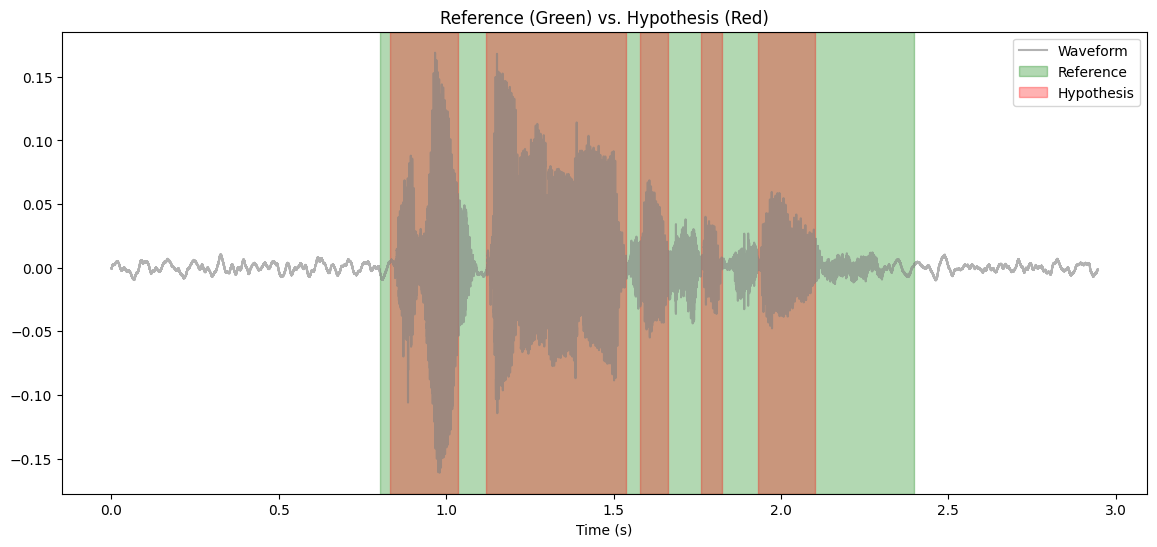

In [120]:

audio_path = speech_path
audio, sr = librosa.load(audio_path, sr=None)
print(sr)
speech_timestamps = get_speech_timestamps(audio, model, sampling_rate=sr)
reference = Annotation()
for speech in speech_timestamps:
    reference[Segment(speech["start"]/sr, speech["end"]/sr)] = "SPEECH"

vad_labels = all_features_vad(audio, sr, frame_length=1024, hop_length=512, n_mfcc=13)
hypothesis = frames_to_annotation(vad_labels, sr, hop_length=512)

visualize_segmentation(audio, sr, reference, hypothesis, title="Reference (Green) vs. Hypothesis (Red)")
